# Setup

In [1]:
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt
from common import transfer_functions, utils

In [2]:
def Epoch(img, s, w_i_h, w_h_o, b_i_h, b_h_o):
    # Forward propagation input -> hidden
    h_pre = b_i_h + w_i_h @ img
    h = transfer_functions.sigmoid(h_pre)
    # Forward propagation hidden -> output
    o_pre = b_h_o + w_h_o @ h
    o = transfer_functions.sigmoid(o_pre)

    # Backpropagation output -> hidden (cost function ddverivative)
    delta_o = o - s  # cross_entropy(s, o) * o
    w_h_o += -learn_rate * delta_o @ np.transpose(h)
    b_h_o += -learn_rate * delta_o

    # Backpropagation hidden -> input (activation function derivative)
    delta_h = np.transpose(w_h_o) @ delta_o * (h * (1 - h))
    w_i_h += -learn_rate * delta_h @ np.transpose(img)
    b_i_h += -learn_rate * delta_h
    return w_i_h, w_h_o, b_i_h, b_h_o

# Train Model

In [ ]:
mazes, solves = utils.load_data("datasets/MazesSolves11.pickle")
w_i_h = np.random.uniform(-0.5, 0.5, (100, 121))
w_h_o = np.random.uniform(-0.5, 0.5, (121, 100))
b_i_h = np.zeros((100, 1))
b_h_o = np.zeros((121, 1))

learn_rate = 0.01
epochs = 40

for epocho in range(epochs):
    for index in range(len(mazes) - 1000):
        img, s = mazes[index], solves[index]
        img.shape += (1,)
        s.shape += (1,)
        w_i_h, w_h_o, b_i_h, b_h_o = Epoch(img, s, w_i_h, w_h_o, b_i_h, b_h_o)

    # Show accuracy for this epoch
    print(f"Epoch #{epocho} ")  # Mean Acc: {np.mean(ac_list) * 100}%  Highest Acc: {np.amax(ac_list) * 100}%"
    # f"  Lowest Acc: {np.amin(ac_list) * 100}%")


utils.store_model("models/11x11MazeModel.pickle", w_i_h, w_h_o, b_i_h, b_h_o)

<Figure size 640x480 with 0 Axes>

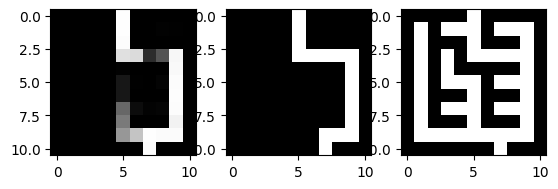

In [12]:
test_index = -50

# Extract Maze
maze = mazes[test_index]
solve = solves[test_index]
maze.shape += (1,)
solve.shape += (1,)


# Forward propagation input -> hidden
h_pre = b_i_h + w_i_h @ maze
h = transfer_functions.sigmoid(h_pre)
# Forward propagation hidden -> output
o_pre = b_h_o + w_h_o @ h
o = transfer_functions.sigmoid(o_pre)

# Show Output
reshaped_maze = 255 - maze.reshape(11, 11) * 255
reshaped_solve = solve.reshape(11, 11) * 255
reshaped_o = o.reshape(11, 11) * 255

maze_img = Image.fromarray(reshaped_maze)
solve_img = Image.fromarray(reshaped_solve)
o_img = Image.fromarray(reshaped_o)

# Creat Plot
plt.figure()
f, axarr = plt.subplots(1,3) 

axarr[0].imshow(maze_img)
axarr[1].imshow(solve_img)
axarr[2].imshow(o_img)
